In [63]:
from solver import ode, rl_solver
import network
import numpy as np
import matplotlib.pyplot as plt
from data import iid


In [64]:
def run_one_exp(seq_length, num_chain, num_iter):
    input_dim = 500
    teachers = []
    students= []
    data_loader = iid.TransientRLTask(batch_size=1, seq_len = [seq_length]*num_chain, input_dim = input_dim)
    teacher = network.ContinuousTeacher(input_dimension=input_dim,
                                  hidden_dimensions=[1],
                                  nonlinearity='sign')
    for i in range(num_chain):
        teachers.append(teacher
        )
        students.append(
        network.ContinuousStudent(input_dimension=input_dim,
                                  hidden_dimensions=[1],
                                  nonlinearity='sign'))
    baseline_rl=rl_solver.MultistepRLPerceptronSolver(criterion=None,
                logdir='.',
                optimizer_type='sgd',
                lr=None,
                lr_positive=10,
                lr_negative=None,
                weight_decay=0,
                teacher_network=teachers,
                student_network=students)


    #ode_baseline=ode.BaselineRLPerceptronODESolver(lr_positive=10., lr_negative =0., seq_length = seq_length , 
    #                                                num_chain = num_chain, total_train_step = total_iter, delta = 0.01, update_frequency = 100 )

    baseline_rl.train(data_loader=data_loader,num_iter=num_iter,update_frequency=1000)
    #ode_baseline.train(100000)
    return baseline_rl
    

In [342]:
class BaselineRLPerceptronODESolver(ode.ODESolver):

    def __init__(self, lr_positive: float, lr_negative: float, seq_length: int,
                 num_chain: int, total_train_step: int, delta: float, std:float,
                 update_frequency: int):
        super().__init__(lr_positive=lr_positive,
                         lr_negative=lr_negative,
                         seq_length=seq_length,
                         delta=delta)

        self.num_chain = num_chain
        self.total_train_step = total_train_step
        self.update_frequency = update_frequency
        self.tot_length = self.seq_length * self.num_chain
        self.std = std
        self.D = 100

    def _init_params(self):
        self.lr_sum = self.lr_negative + self.lr_positive
        self.teachers = []
        
        p_term = 1.0
        exp_reward = 1.0
        for i in range(self.num_chain):
            """
            
            teacher_network=network.ContinuousTeacher(input_dimension=self.D,
                                  hidden_dimensions=[1],
                                  nonlinearity='sign')
            """
            teacher_network=network.ContinuousTeacher(input_dimension=self.D,
                                  hidden_dimensions=[1],
                                  nonlinearity='sign')
            QT = (teacher_network.layers[0].weight.data @ teacher_network.layers[0].weight.data.T).item()/self.D
            student_network=network.ContinuousStudent(input_dimension=self.D,
                                      hidden_dimensions=[1],
                                      nonlinearity='sign')
            teacher_network.layers[0].weight.data-=np.mean(teacher_network.layers[0].weight.data.numpy())
            teacher_network.layers[0].weight.data/=np.sqrt(QT)
            Q = (student_network.layers[0].weight.data @ student_network.layers[0].weight.data.T).item()/ self.D
            self.teachers.append(teacher_network.layers[0].weight.data.numpy())
            R = (teacher_network.layers[0].weight.data @ student_network.layers[0].weight.data.T).item() / self.D
            """
            e = np.random.normal(0, self.std)
            Q = 1. + abs(e)
            R = e
            """
            Q= 1.
            QT = 1.
            R = 0.
            P = 1 - (1 / np.pi) * np.arccos(R / np.sqrt(Q))
            p_term *= np.power(P, self.seq_length-1)
            exp_reward *= np.power(P, self.seq_length)
            setattr(self, f"Q{i}", Q)
            setattr(self, f"R{i}", R)
            setattr(self, f"P{i}", P)
            setattr(self, f"QT{i}", QT)
            print(P, R, Q, QT)
        self.train_iter = 0
        self.p_term = p_term
        self.exp_reward = exp_reward

    def _step(self):

        exp_reward = 1
        p_term = 1
        for i in range(self.num_chain):
            P = getattr(self, f"P{i}")
            Q = getattr(self, f"Q{i}")
            QT = getattr(self, f"QT{i}")
            R = getattr(self, f"R{i}")

            dR = (self.lr_sum) / np.sqrt(
                2 * np.pi) * (1 + R / np.sqrt(Q)) * np.power(P, self.tot_length-1) - self.lr_negative * R * np.sqrt(
                        2 / (np.pi * Q))

            dQ = (self.lr_sum) * np.sqrt(
                2 * Q / np.pi) * (1 + R / np.sqrt(Q)) * np.power(P, self.tot_length-1) - 2 * self.lr_negative * np.sqrt(2 * Q / np.pi) + (
                        self.lr_positive**2 - self.lr_negative**2
                    ) / self.seq_length * np.power(P, self.tot_length) + self.lr_negative**2 / self.seq_length

            R += self.delta * dR
            Q += self.delta * dQ
            P = 1 - (1 / np.pi) * np.arccos(R / np.sqrt(Q))
            setattr(self, f"Q{i}", Q)
            setattr(self, f"R{i}", R)
            setattr(self, f"P{i}", P)
            exp_reward *= np.power(P, self.seq_length)
        self.exp_reward = exp_reward
        if self.train_iter % self.update_frequency == 0:
            self._update_history(exp_reward=exp_reward, R1=self.R1, Q1=self.Q1, R2=self.R2, Q2=self.Q2)
        self.train_iter += 1

    def _setup_history(self):
        self.history = {'exp_reward': [], 'R1':[], 'Q1':[], 'R2':[], 'Q2':[]}

In [337]:
ode_baseline.exp_reward

0.9493410660282131

In [ ]:
seq_length = 3
num_chain = 7
num_iter = 600000
baselines=[]
for std in range(2):
    
    ode_baseline=BaselineRLPerceptronODESolver(lr_positive=10., lr_negative =0., seq_length = seq_length , 
                                                        num_chain = num_chain, total_train_step = num_iter, delta = 0.01, std = std, update_frequency = 10000 )
    ode_baseline.train(num_iter)
    baselines.append(ode_baseline)

In [ ]:
for i in range(2):
    plt.plot(baselines[i].history['exp_reward'][:20], label = f'ode_{i}')
plt.title('Different teacher weights for all task')
plt.legend()

In [298]:
np.mean(overlap[2])

0.0

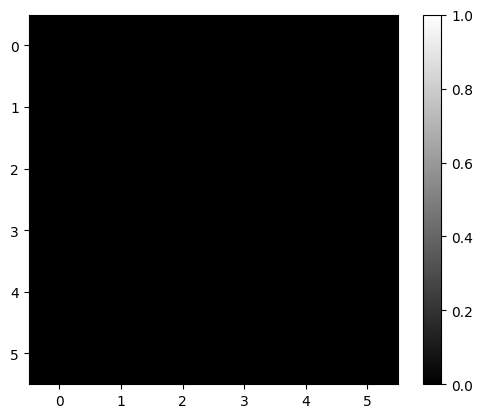

In [299]:
plt.imshow(overlap[2], vmin = 0, vmax=1, cmap = 'gray')
plt.colorbar()

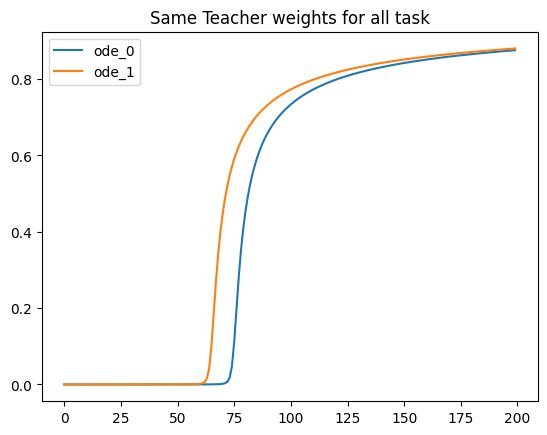

In [319]:
for i in range(2):
    plt.plot(baselines_same[i].history['exp_reward'], label = f'ode_{i}')
plt.title('Same Teacher weights for all task')
plt.legend()

In [292]:
baselines_same[2].P0

0.9909979936044958

In [172]:
baselines[0].P4

0.4692308937573163

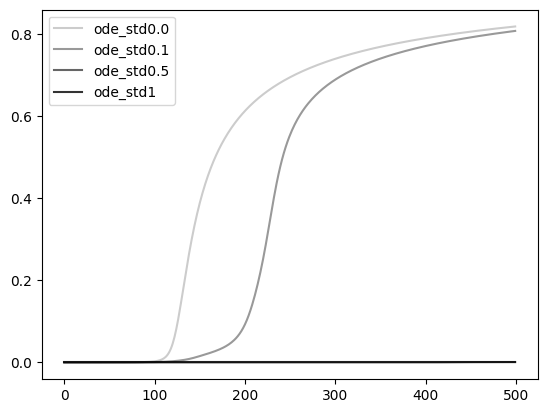

In [80]:
alpha = 0.2
c=0
for std, h in zip([0.0, 0.1, 0.5, 1], baselines):
    c+=1
    plt.plot(h.history['exp_reward'], label=f'ode_std{std}', c='k', alpha = c*alpha)
#plt.plot(ode_baseline.history['exp_reward'], c = 'k', label = 'ode')
#plt.plot(ode_baseline_noise.history['exp_reward'], c = 'gray', label = 'ode_noise')
plt.plot(results5[0].history['exp_reward'], label = f'simul_std0.0', c= 'red')
plt.legend()

In [3]:
seq_length = 3
num_chain = 7

total_iter = 6000000

ode_baseline=ode.BaselineRLPerceptronODESolver(lr_positive=10., lr_negative =0., seq_length = seq_length , 
                                                num_chain = num_chain, total_train_step = total_iter, delta = 0.01, update_frequency = 10000 )
ode_baseline.train(total_iter)

In [15]:
import joblib
joblib.load('ode_logs/len_3_chain_3/20230510152923/baseline.jl')

{'exp_reward': [0.0019548687575035397,
  0.0021362656085014775,
  0.002332185969480134,
  0.00254360806283898,
  0.002771585257496493,
  0.0030172531275266907,
  0.003281836574451388,
  0.003566656970453588,
  0.0038731392835951355,
  0.004202819145481877],
 'P0': [0.5000495805430412,
  0.5050042437177475,
  0.5099519326389361,
  0.51489264491472,
  0.5198268329774327,
  0.5247553326890354,
  0.529679292185323,
  0.5346001029250849,
  0.5395193343584466,
  0.5444386731357302]}

In [7]:
train_per_step = 500000

ode_chained=ode.MultistepRLPerceptronODESolver(lr_positive=10., lr_negative =0., seq_length = seq_length , 
                                                num_chain = num_chain, train_per_chain = train_per_step, delta = 0.01, update_frequency = 10000, threshold = True )
ode_chained.train(train_per_step * num_chain)

In [14]:
len(ode_chained.history['exp_reward'])

350

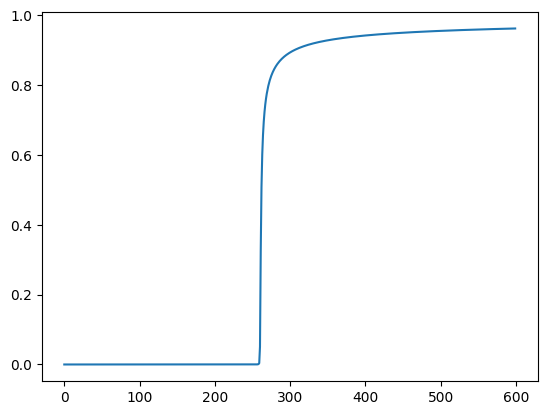

In [4]:
#plt.plot(ode_chained.history['exp_reward'])
plt.plot(ode_baseline.history['exp_reward'])


In [18]:
ode_base=ode.MultistepRLPerceptronODESolver(lr_positive=10., lr_negative =0., seq_length = seq_length*num_chain , 
                                                num_chain = 1, train_per_chain = 10000000, delta = 0.01, update_frequency = 10000, threshold = True )
ode_base.train(10000000)

In [13]:
ode_base.history['exp_reward'][0]

0.0007992551387014076

In [17]:
0.7**(21)

0.0005585458640832833